## Pixel-Based Class Identifier

This script shows the full training and prediction pipeline for a pixel-based classifier: we create a mask, train logistic regression on one-pixel patches, make prediction for all pixels, create and smooth polygons from pixels.

This notebook can be found at https://www.kaggle.com/lopuhin/full-pipeline-demo-poly-pixels-ml-poly/data/notebook

Or by going to https://www.kaggle.com/c/dstl-satellite-imagery-feature-detection and selecting "Full pipeline demo: poly -> pixels -> ML -> poly" by Konstantin Lopuhin under Kernels and viewing the Notebook and Data.

#### Object types in the geo data
In a satellite image, you will find lots of different objects like roads, buildings, vehicles, farms, trees, water ways, etc. Dstl has labeled 10 different classes:

1. Buildings - large building, residential, non-residential, fuel storage facility, fortified building
2. Misc. Manmade structures 
3. Road 
4. Track - poor/dirt/cart track, footpath/trail
5. Trees - woodland, hedgerows, groups of trees, standalone trees
6. Crops - contour ploughing/cropland, grain (wheat) crops, row (potatoes, turnips) crops
7. Waterway 
8. Standing water
9. Vehicle Large - large vehicle (e.g. lorry, truck,bus), logistics vehicle
10. Vehicle Small - small vehicle (car, van), motorbike


Every object class is described in the form of Polygons and MultiPolygons, which are simply a list of polygons. We provide two different formats for these shapes: GeoJson and WKT. These are both open source formats for geo-spatial shapes. 

In [1]:
from collections import defaultdict
import csv
import sys
import glob
import os

import cv2
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
import numpy as np
import tifffile as tiff

import numpy as np
import matplotlib.pyplot as plt
from scipy import misc

%matplotlib inline

csv.field_size_limit(pow(2, 31)-1) # ensure for 32 bit

131072

We'll work on buildings (class 1) from image 6120_2_2. Fist load grid sizes and polygons.

Using data from https://www.kaggle.com/lopuhin/full-pipeline-demo-poly-pixels-ml-poly/data/data

A helper for nicer display

In [2]:
def scale_percentile(matrix):
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)
    # Get 2nd and 98th percentile
    mins = np.percentile(matrix, 1, axis=0)
    maxs = np.percentile(matrix, 99, axis=0) - mins
    matrix = (matrix - mins[None, :]) / maxs[None, :]
    matrix = np.reshape(matrix, [w, h, d])
    matrix = matrix.clip(0, 1)
    return matrix

#### Folder structure for data in project folder

```

data
  \input
    image1_name.tif
  \output_jpg_class_<name>
    image1_name.jpg
  \output_mask_class_<name>
    image1_name.jpg
```

where `<name>` is the name of the class.  The `image1_name.jpg` under `output_jpg_class_<name>` folder and `output_mask_class_<name>` folder are different images (first is the RGB and second is the binary mask image based on the polygon geo data).  

The second and third folders get creeated if not already in this notebook.

In [3]:
# Create a list of existing tif files and names list for output files
img_files = glob.glob(os.path.join('data', 'input','*.tif'))
img_files_out = [s.replace('tif', 'jpg') for s in img_files]

#### Create output folders

In [4]:
if not os.path.exists(os.path.join('data','output_jpg_class_tree')):
    os.mkdir(os.path.join('data','output_jpg_class_tree'))
if not os.path.exists(os.path.join('data','output_jpg_class_crop')):
    os.mkdir(os.path.join('data','output_jpg_class_crop'))
if not os.path.exists(os.path.join('data','output_mask_class_tree')):
    os.mkdir(os.path.join('data','output_mask_class_tree'))
if not os.path.exists(os.path.join('data','output_mask_class_crop')):
    os.mkdir(os.path.join('data','output_mask_class_crop'))

Function to scale polygons to match image:

In [5]:
def get_scalers(im_size):
    h, w = im_size  # they are flipped so that mask_for_polygons works correctly
    w_ = w * (w / (w + 1))
    h_ = h * (h / (h + 1))
    return w_ / x_max, h_ / y_min

Function to create a mask from polygons:

In [6]:
def mask_for_polygons(polygons):
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask

In [7]:
def save_mask(m, f):
    # hack for nice display
    w, h, d = m.shape
    matrix = np.reshape(m, [w * h, d]).astype(np.float64)
    misc.imsave(f, matrix)

In [ ]:

POLY_TYPE = '5'  # trees or crops
for f in img_files_out:
    
    IM_ID = os.path.basename(f).replace('.jpg', '')
    print(IM_ID)
    
    # Load grid size
    x_max = y_min = None
    for _im_id, _x, _y in csv.reader(open(
        os.path.join('data', 'grid_sizes.csv'))):
        if _im_id == IM_ID:
            x_max, y_min = float(_x), float(_y)
            break

    # Load train poly with shapely
    train_polygons = None
    for _im_id, _poly_type, _poly in csv.reader(open(
        os.path.join('data', 'train_wkt_v4.csv'))):
        if _im_id == IM_ID and _poly_type == POLY_TYPE:
            train_polygons = shapely.wkt.loads(_poly)
            break
            
    if train_polygons is None or x_max is None:
        continue
            
    im_rgb = tiff.imread(f.replace('jpg', 'tif')).transpose([1, 2, 0])
    im_size = im_rgb.shape[:2]
    
    misc.imsave(os.path.join('output1_xyz',f), (255 * scale_percentile(im_rgb)))
    
    x_scaler, y_scaler = get_scalers(im_size)
    train_polygons_scaled = shapely.affinity.scale(
        train_polygons, xfact=x_scaler, yfact=y_scaler, origin=(0, 0, 0))
    train_mask = mask_for_polygons(train_polygons_scaled)
    save_mask((255 * np.stack([train_mask])),
              os.path.join('output2_xyz', f.replace('.jpg', '_mask.jpg')))
    

In [8]:
# The order with which we want to color our classes on the image "paint them on"
CLASS_ORDER = [6, 7, 8, 5, 4, 3, 1, 2, 9, 10]

In [9]:
# 1. Buildings - large building, residential, non-residential, fuel storage facility, fortified building
# 2. Misc. Manmade structures 
# 3. Road
# 4. Track - poor/dirt/cart track, footpath/trail
# 5. Trees - woodland, hedgerows, groups of trees, standalone trees
# 6. Crops - contour ploughing/cropland, grain (wheat) crops, row (potatoes, turnips) crops
# 7. Waterway 
# 8. Standing water
# 9. Vehicle Large - large vehicle (e.g. lorry, truck,bus), logistics vehicle
# 10. Vehicle Small - small vehicle (car, van), motorbike

COLORS = [
    (255,105,180), # Pink
    (148,0,211), # Dark Violet
    (190,190,190), # Gray
    (255,255,0), # Yellow
    (0,100,0), # Forest Green
    (143,188,143), # Dark Sea Green
    (0,0,255), # Blue
    (64,224,208), # Turquoise
    (49,79,79), # Dark Slate Gray
    (178,34,34) # 7 Firebrick Red
]

#### Color pixels by class

(11356459, 3)
6
(143, 188, 143)
7
(0, 0, 255)
8
(64, 224, 208)
5
(0, 100, 0)
4
(255, 255, 0)
3
(190, 190, 190)
1
(255, 105, 180)
2
(148, 0, 211)
9
(49, 79, 79)
10
(178, 34, 34)


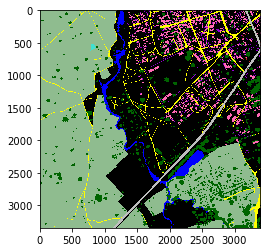

In [10]:
# Color-code an image based on classes and polygons
IM_ID = '6100_2_2'
# IM_ID = '6110_4_0' # another with 10 classes represented
# IM_ID = '6010_4_2' # two classes represented

im_rgb = tiff.imread(os.path.join('data', 'input', 
                                  IM_ID + '.tif')).transpose([1, 2, 0])
im_size = im_rgb.shape[:2]

len(im_rgb.flatten())
class_desig = np.zeros(im_rgb.shape[0]*im_rgb.shape[1], 
                       dtype=(float,3))
print(class_desig.shape)

# Load grid size
x_max = y_min = None
for _im_id, _x, _y in csv.reader(open(
    os.path.join('data', 'grid_sizes.csv'))):
    if _im_id == IM_ID:
        x_max, y_min = float(_x), float(_y)
        break

clr_idx = 0
for POLY_TYPE in CLASS_ORDER:
    print(POLY_TYPE)

    # Load train poly with shapely
    train_polygons = None
    for _im_id, _poly_type, _poly in csv.reader(open(
        os.path.join('data', 'train_wkt_v4.csv'))):
        if _im_id == IM_ID and _poly_type == str(POLY_TYPE):
            train_polygons = shapely.wkt.loads(_poly)
            break

    if train_polygons is None or x_max is None:
        continue

    x_scaler, y_scaler = get_scalers(im_size)
    train_polygons_scaled = shapely.affinity.scale(
        train_polygons, xfact=x_scaler, yfact=y_scaler, origin=(0, 0, 0))
    train_mask = mask_for_polygons(train_polygons_scaled)
    
    a = train_mask.flatten()
    class_desig[np.where(a == 1)] = COLORS[POLY_TYPE-1]
    clr_idx+=1
    print(COLORS[POLY_TYPE-1])
    
#TODO:  reshape better
    
r = np.array([x[0] for x in class_desig]).reshape(im_size)
g = np.array([x[1] for x in class_desig]).reshape(im_size)
b = np.array([x[2] for x in class_desig]).reshape(im_size)

res = np.stack([r, g, b], axis=2) * 255

plt.imshow(res)
misc.imsave('6100_2_2_all_classes.jpg', res)